# Libraries & Modules for YAMNet

In [38]:
!pip install tensorflow_io==0.29.0

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import glob
import json
import re

2024-02-15 09:04:48.581270: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 09:04:48.604728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 09:04:48.604749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 09:04:48.604774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 09:04:48.609893: I tensorflow/core/platform/cpu_feature_g

# Load pretrained models & samples

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2024-02-15 09:04:51.596286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 09:04:51.617292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 09:04:51.617461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

./test_data/miaow_16k.wav


In [5]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2024-02-15 09:05:05.719780: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-02-15 09:05:05.992162: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-02-15 09:05:05.992180: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-02-15 09:05:05.992220: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-15 09:05:05.992444: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-15 09:05:05.992455: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc

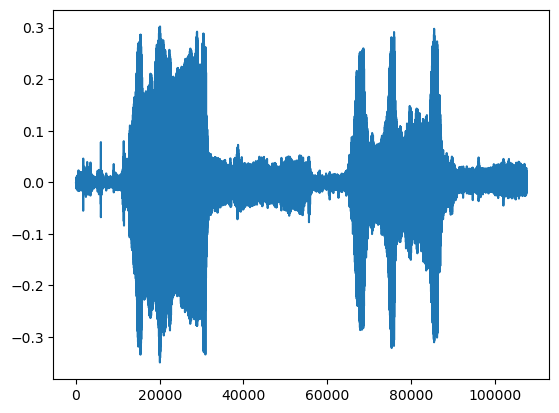

In [6]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

# Load class mappings

In [7]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

In [8]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

2024-02-15 09:05:11.075704: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-15 09:05:11.666263: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-15 09:05:11.768293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


The main sound is: Animal
The embeddings shape: (13, 1024)


2024-02-15 09:05:12.132074: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-15 09:05:12.150067: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


# Load datasets

In [9]:
"""
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""
!pwd

/data/GDSC_AudioPoli


In [10]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)
# valid_orig_files = glob.glob(base_valid_audio + '**/*.wav', recursive=True)

# print(train_json_files, train_orig_files)

def process_json_file(json_file):
    target = re.split('[/._]', json_file)[-2]
    result = [file for file in train_orig_files \
              if "_{0}_".format(target) in file]
    result = result[0] if len(result) > 0 else None
    data = json.load(open(json_file))
    data = pd.json_normalize(data)
    annotations = data['annotations'][0]
    # print(annotations)
    data = []
    for annotation in annotations:
        item = {}
        item['filename'] = result
        item['target'] = target
        item['category'] = annotation['categories']['category_02']
        item['audio_type'] = annotation['audioType']
        data.append(item)

    # print("{0}\n{1}\n".format(json_file, result))
    # print("{0} {1}_{2}".format(target, re.split('[/.\[\]_]', result)[-4], re.split('[/._]', result)[-1]))
    return data


# print(len(training_json_files), len(validation_json_files))
# print(training_json_files[:5], validation_json_files[:5])


all_data = []
"""
for file in train_json_files:
# for file in valid_json_files:
    data = process_json_file(file)
    all_data.extend(data)

# Create a DataFrame from the collected data
df = pd.DataFrame(all_data)

# Write the DataFrame to a CSV file
df.to_csv('output.csv', index=False)
# df.to_csv('output_valid.csv', index=False)
"""

"\nfor file in train_json_files:\n# for file in valid_json_files:\n    data = process_json_file(file)\n    all_data.extend(data)\n\n# Create a DataFrame from the collected data\ndf = pd.DataFrame(all_data)\n\n# Write the DataFrame to a CSV file\ndf.to_csv('output.csv', index=False)\n# df.to_csv('output_valid.csv', index=False)\n"

In [11]:
print(len(all_data))
# df.head()

0


### Experiments (Don't run)

In [ ]:
base_train_dir = "/data/GDSC_AudioPoli/testset/Training/label/"
base_valid_dir = "/data/GDSC_AudioPoli/testset/Validation/label/"
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'

train_json_files = glob.glob(os.path.join(base_train_dir, '*/*.json'))
valid_json_files = glob.glob(os.path.join(base_valid_dir, '*/*.json'))
train_orig_files = glob.glob(os.path.join(base_train_audio, '*/*.wav'), recursive=True)
valid_orig_files = glob.glob(os.path.join(base_valid_audio, '*/*.wav'), recursive=True)

json_file = "/data/GDSC_AudioPoli/testset/Validation/label/[라벨]8.전기사고/8.전기사고_236859.json"
target = re.split('[/._]', json_file)[-2]
result = [file for file in valid_orig_files \
          if "_{0}_".format(target) in file][0]
print(target, result)

In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = "_{0}_".format(re.split('[/._]', tmp)[-2])
print(foo)

train_orig_list = glob.glob(path + '**/*.wav', recursive=True)
print(all_wav_files[:5])

result = [file for file in train_orig_list if foo in file]
print(result)

In [ ]:
path = "/data/GDSC_AudioPoli/testset/Training/orig/"
tmp = "/data/GDSC_AudioPoli/testset/Training/label/[라벨]8.전기사고/8.전기사고_226549.json"
foo = re.split('[/._]', tmp)[-2]
result = [filename for filename in glob.glob("{0}**/*_{1}_label.wav".format(path, foo), recursive=True)][0]
print(foo, result)

### Check

In [14]:
output_csv = '/data/GDSC_AudioPoli/output.csv'
output_valid_csv = '/data/GDSC_AudioPoli/output_valid.csv'
base_train_audio = '/data/GDSC_AudioPoli/testset/Training/orig/'
base_valid_audio = '/data/GDSC_AudioPoli/testset/Validation/orig/'


pd_data = pd.read_csv(output_csv)
pd_data.head(10)

,filename,target,category,audio_type
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,전기사고,voice
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,전기사고,voice
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,전기사고,voice
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,전기사고,voice
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,전기사고,voice
5,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,168183,전기사고,voice
6,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1147795,전기사고,voice
7,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,155910,전기사고,voice
8,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,181836,전기사고,voice
9,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234356,전기사고,voice


In [15]:
pd_data

,filename,target,category,audio_type
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,전기사고,voice
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,전기사고,voice
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,전기사고,voice
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,전기사고,voice
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,전기사고,voice
...,...,...,...,...
447060,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,594834,절도범죄,voice
447061,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1238090,절도범죄,voice
447062,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1238011,절도범죄,voice
447063,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,595821,절도범죄,voice


### Drop columns with lost filenames

In [ ]:
# pd_data.to_csv('output_dropna.csv', index=False)

# Data Filtering

In [16]:
from sklearn import model_selection

output_dropna_csv = '/data/GDSC_AudioPoli/output_dropna.csv'
pd_data = pd.read_csv(output_dropna_csv)

my_classes = ['강제추행(성범죄)', '강도범죄', '절도범죄', '폭력범죄',
              '화재', '갇힘', '응급의료', '전기사고', '가스사고', '낙상', 
              '붕괴사고', '태풍-강풍', '지진', '도움요청', '실내', '실외'
             ]
map_class_to_id = {'강제추행(성범죄)':1, '강도범죄':2, '절도범죄':3, '폭력범죄':4,
              '화재':5, '갇힘':6, '응급의료':7, '전기사고':8, '가스사고':9, '낙상':10, 
              '붕괴사고':11, '태풍-강풍':12, '지진':13, '도움요청':14, '실내':15, '실외':16}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(category=class_id)

# KFold (n = 5)
filtered_pd['fold'] = -1
kf = model_selection.KFold(n_splits = 5)
for fold, (trn_, val_) in enumerate(kf.split(X=filtered_pd)):
    filtered_pd.loc[val_, 'fold'] = fold

# filtered_pd['Fold'].unique()
    
filtered_pd.head(10)

,filename,target,category,audio_type,fold
0,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,226549,8,voice,0
1,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,220721,8,voice,0
2,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,232239,8,voice,0
3,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234023,8,voice,0
4,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,222619,8,voice,0
5,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,168183,8,voice,0
6,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,1147795,8,voice,0
7,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,155910,8,voice,0
8,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,181836,8,voice,0
9,/data/GDSC_AudioPoli/testset/Training/orig/[원천...,234356,8,voice,0


# Audio file embeddings

In [17]:
filenames = filtered_pd['filename']
targets = filtered_pd['category']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# K-Fold


In [20]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model for embeddings

In [21]:
from tensorflow.keras import layers, models

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

"""
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,  3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Conv2D(64, kernel_size=(3,  3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Conv2D(128, kernel_size=(3,  3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,  2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
"""

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 16)                8208      
                                                                 
Total params: 533008 (2.03 MB)
Trainable params: 533008 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [23]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


2024-02-15 09:06:16.358498: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.358621: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.358642: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.358667: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.358902: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.358929: W tensorflow/core/framework/op_kernel.cc:1839] 

InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16738]

2024-02-15 09:06:16.500783: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.508678: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.508824: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.518981: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.519247: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Can only read 16-bit WAV files, but received 32
2024-02-15 09:06:16.519300: W tensorflow/core/framework/op_kernel.cc:1839] 

### Check with wav metadata

In [65]:
num_channels = []
file_name = []
for wav_file in filtered_pd['filename']:
    file = open(wav_file, 'rb')
    l1 = file.readline()
    num_channels.append(l1)
    file_name.append(wav_file)

In [67]:
for i in range(len(num_channels)):
    if num_channels[i][8:12] != b'WAVE':
        print('File name : {0}'.format(file_name[i]))
        print('Chunk ID : {0}'.format(num_channels[i][0:4]))
        print('Chunk Size : {0}'.format(num_channels[i][4:8]))
        print('Format : {0}'.format(num_channels[i][8:12]))
        print('Chunk ID : {0}'.format(num_channels[i][12:16]))
        print('Chunk Size : {0}'.format(num_channels[i][16:20]))
        print('Audio Format : {0}'.format(num_channels[i][20:22]))
        print('Channel number : {0}'.format(num_channels[i][22:24]))
        print("----------------------------------------")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1105532_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\x80\x19\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_958042_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\xec\xb5\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1100154_label.wav
Chunk ID : b'RIFF'
Chunk Size : b'\xb4\x1f\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
----------------------------------------
File name : /data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1033548_label.wav
Chunk ID : b'RIFF'
Chunk Size : b' 7\n'
Format : b''
Chunk ID : b''
Chunk Size : b''
Audio Format : b''
Channel number : b''
---

In [47]:
from collections import Counter
Counter(num_channels)

Counter({b'\x00\x02': 293494,
         b'\x00\x01': 113266,
         b'': 34065,
         b'\x00\x03': 694})

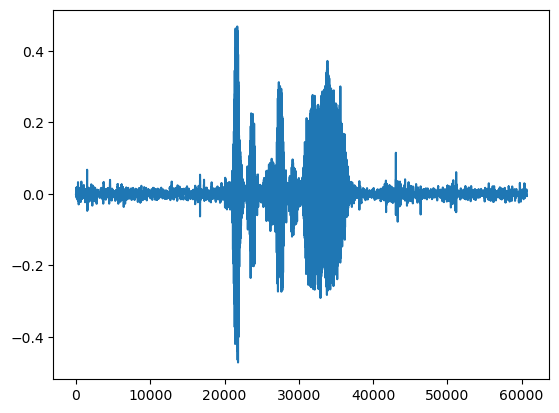

In [71]:
tmp = load_wav_16k_mono("/data/GDSC_AudioPoli/testset/Training/orig/[원천]5.화재_1/5.화재_1033548_label.wav")

_ = plt.plot(tmp)

# Play the audio file.
display.Audio(tmp, rate=16000)

In [ ]:
# Check for overfittings

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

# Testing model


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

### Pipelines for wave-input model

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


# Comparison with YAMNet models

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')